<h1>Convex Multi-Task Feature Learning</h1>

<i>Guillaume Richard, Antoine Simoulin</i>

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

data=pd.read_csv('./data/school_results.csv')
X_train = pd.DataFrame(data)
X_train.drop(['grade','tasks'], axis=1, inplace=True)
Y_train = pd.DataFrame(data['grade'])
Tasks = pd.DataFrame(data['tasks'])

In [429]:
import numpy as np
from numpy import linalg as LA

class MLT_Task():
    def __init__(self, X, Y, gamma=1, l_rate=1e-5, n_epoch=15, N = 5, penalization=False, verbose=0):
        self.N = N # dimension representation space
        self.d = X[0].shape[1] # number of features
        self.gamma = gamma # penalization term
        self.l_rate = l_rate # learning rate
        self.n_epoch = n_epoch # number of epochs
        self.X = X # list of matrix of shape (m[i],d)
        self.Y = Y # list of matrix of shape (m[i],1)
        self.T = len(X) # number of tasks
        self.m = [X[i].shape[0] for i in range(len(X))] # number of individuals for each task, list of len(T)
        self.X_conc = np.vstack(X) # aggregated data on all tasks
        self.M = np.vstack(X).shape[0] # total number of individuals
        self.U_0 = np.random.rand(self.d,self.N) # initial representation matrix of shape (d,N)
        self.A_0 = np.random.rand(self.T,self.N) # initial regression matrix of shape (N,T)
        self.penalization = penalization
        self.verbose = verbose
        
        self.index_task = [0]*(self.T+1)# index of each task in global vector X_low and X_conc
        for t in range(1,self.T):
            self.index_task[t] = self.index_task[t-1] + self.m[t-1]
        self.index_task[self.T] = self.M
        
        self.reverse_index_task = np.zeros(self.M, dtype=int)
        for t in range(self.T):
            self.reverse_index_task[self.index_task[t]:self.index_task[t+1]] = t
        
        if self.verbose==1:
            print('_'*100)
            print('number of tasks (T) : %i' %self.T)
            print('features space lower dimension (N) : %i' %self.N)
            print('original feature space dimension (d) : %i\n' %self.d)
        
    def Loss_function(self, A, U):
        X_low = np.dot(self.X_conc, U) # data in lower dimensional space
        # regression, list of len(T) of matrix of shape (m[i],1)
        Y_hat = [X_low[self.index_task[t]:self.index_task[t+1],:] @ A[t] for t in range(self.T)]
        
        # compute loss
        L = 0
        for t in range(self.T):
            for i in range(self.m[t]):
                L += (Y_hat[t][i]-self.Y[t][i])**2 # average error across tasks
                
        # penalization term
        if self.penalization:
            A2 = LA.norm(A, 2, axis=1)
            A2 = LA.norm(A2, 2) # /!\ norm change, should be one ! here trace norm
            pen = self.gamma*A2
            L += pen
        
        return L, Y_hat

    def grad(self, A, U, t, i):
        grad_A_t = -(2*(self.Y[t][i] - self.X[t][i] @ U @ A[t])*(U.T @ self.X[t][i].T))
        grad_U = -(2 * (self.Y[t][i] - self.X[t][i] @ U @ A[t]) * (self.X[t][i].reshape(1, self.d).T @ A[t].reshape(self.N,1).T))
        grads = {"A_t": grad_A_t, "U": grad_U}
        return grads
    
    def explained_var(self, y_pred, y_train):
        #Computes the explained variance
        SS_err = np.linalg.norm(y_pred-y_train)**2/len(y_pred)
        SS_tot = np.var(y_train)
        return 1-SS_err/SS_tot

    # Estimate linear regression coefficients using stochastic gradient descent
    def opt(self):
        r = list(range(self.M))
        A = self.A_0
        U = self.U_0
        for epoch in range(self.n_epoch):
            random.shuffle(r)
            for i in r:
                t =  self.reverse_index_task[i]
                grad = self.grad(A, U, t, i-self.index_task[t])
                # coeff update
                A[t] = A[t] - self.l_rate * grad['A_t']
                U = U - self.l_rate * grad['U']
            self.l_rate = self.l_rate / (1 + epoch)
            loss, pred = self.Loss_function(A, U)
            Y_pred = np.hstack(pred)
            Y_train =  np.hstack(self.Y)
            Y_pred = Y_pred.reshape(Y_pred.shape[0],1)
            Y_train = Y_train.reshape(Y_train.shape[0],1)
            expl_var = self.explained_var(Y_pred, Y_train)
            if self.verbose==1:
                print('>epoch = %2d, loss = %3.2f, explained var = %3.2f' % (epoch, np.sqrt(loss/self.M), expl_var))
        if self.verbose==1:
            print('_'*100)
        return A, U, pred, np.sqrt(loss/self.M), expl_var
    
    def grad_F(self, A, U):
        grad_A_t = np.zeros(A.shape)
        grad_U = np.zeros(U.shape)
        for t in range(self.T):
            for i in range(self.m[t]):
                grad_A_t[t] += -(2*(self.Y[t][i] - self.X[t][i] @ U @ A[t]) * (U.T @ self.X[t][i].T))
                grad_U += -(2 * (self.Y[t][i] - self.X[t][i] @ U @ A[t]) * (self.X[t][i].reshape(1, self.d).T @ A[t].reshape(self.N,1).T))
        grads = {"A": grad_A_t, "U": grad_U}
        return grads
    
    def operator_prox(self, A, eps):
        u, s, v = np.linalg.svd(A)
        s=[max(s_-0.1,0) for s_ in s]
        ss = np.zeros((len(u),len(v)))
        l = min(len(u), len(v))
        ss[:l,:l] = np.diag(s)
        return u @ ss @ v
        
    def algo_prox(self, nb_iter=200):
        eps = 1e-9
        U = self.U_0
        A = self.A_0

        for it in range(nb_iter):
            grad = self.grad_F(A, U)
            U = U - eps * grad['U']
            A = A - eps * grad['A']
            A = self.operator_prox(A, eps)
            
            loss, pred = self.Loss_function(A, U)
            Y_pred = np.hstack(pred)
            Y_train =  np.hstack(self.Y)
            Y_pred = Y_pred.reshape(Y_pred.shape[0],1)
            Y_train = Y_train.reshape(Y_train.shape[0],1)
            expl_var = self.explained_var(Y_pred, Y_train)
            
            if self.verbose==1:
                print('>iter = %2d, loss = %3.2f, explained var = %3.2f' % (it, np.sqrt(loss/self.M), expl_var))
        
        return A, U, np.sqrt(loss/self.M), pred, expl_var

In [430]:
# test parameters
X_train_list = [X_train[Tasks.tasks == t].values for t in Tasks.tasks.unique()]
Y_train_list = [Y_train[Tasks.tasks == t].values[:,0] for t in Tasks.tasks.unique()]

MLT_Task_test = MLT_Task(X_train_list, Y_train_list, N=28, n_epoch=10, l_rate=1e-5, verbose=0, penalization=True)
A, U, val, pred, var = MLT_Task_test.algo_prox()
print(val, var)

12.8773954543 -0.0246631003768


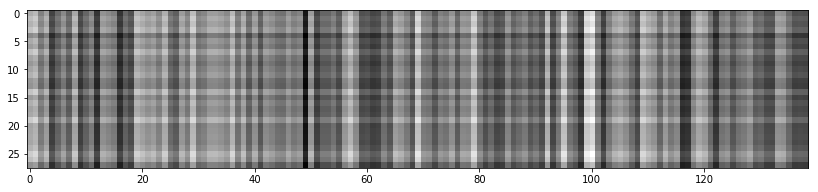

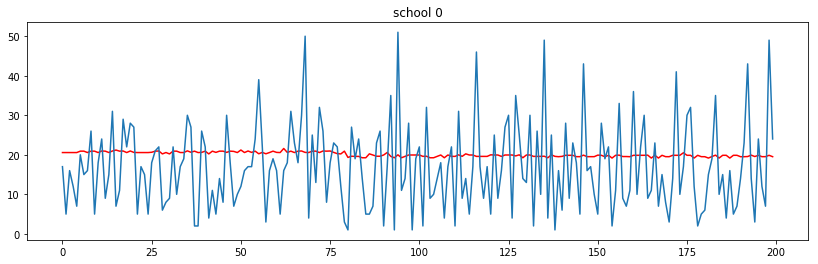

In [433]:
fig, _ = plt.subplots(figsize=[14,8])
plt.imshow(A.T,cmap='gray')
plt.show()

fig, _ = plt.subplots(figsize=[14,4])
plt.plot(pred[0],'r')
plt.plot(Y_train_list[0])
plt.title('school 0')
plt.show()

____________________________________________________________________________________________________
number of tasks (T) : 139
features space lower dimension (N) : 2
original feature space dimension (d) : 28

>epoch =  0, loss = 12.08, explained var = 0.10
>epoch =  1, loss = 11.86, explained var = 0.13
>epoch =  2, loss = 11.72, explained var = 0.15
>epoch =  3, loss = 11.70, explained var = 0.15
>epoch =  4, loss = 11.68, explained var = 0.16
>epoch =  5, loss = 11.67, explained var = 0.16
>epoch =  6, loss = 11.67, explained var = 0.16
>epoch =  7, loss = 11.67, explained var = 0.16
>epoch =  8, loss = 11.67, explained var = 0.16
>epoch =  9, loss = 11.67, explained var = 0.16
____________________________________________________________________________________________________


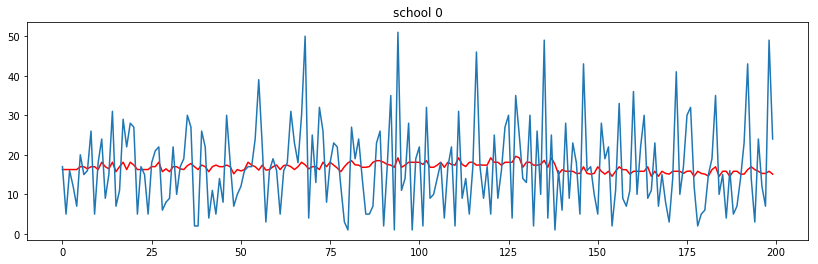

In [434]:
# test parameters
X_train_list = [X_train[Tasks.tasks == t].values for t in Tasks.tasks.unique()]
Y_train_list = [Y_train[Tasks.tasks == t].values[:,0] for t in Tasks.tasks.unique()]

MLT_Task_test = MLT_Task(X_train_list, Y_train_list, N=2, n_epoch=10, l_rate=1e-5, verbose=1)
_, _, pred, _, _ = MLT_Task_test.opt()


fig, _ = plt.subplots(figsize=[14,4])
plt.plot(pred[0],'r')
plt.plot(Y_train_list[0])
plt.title('school 0')
plt.show()

In [332]:
LOSS = [0]*27
VAR = [0]*27

for n in range(1,28):
    MLT_Task_test = MLT_Task(X_train_list, Y_train_list, N=n, n_epoch=4, l_rate=1e-5)
    _, _, _, loss, expl_var = MLT_Task_test.opt()
    LOSS[n-1] = loss
    VAR[n-1] = expl_var

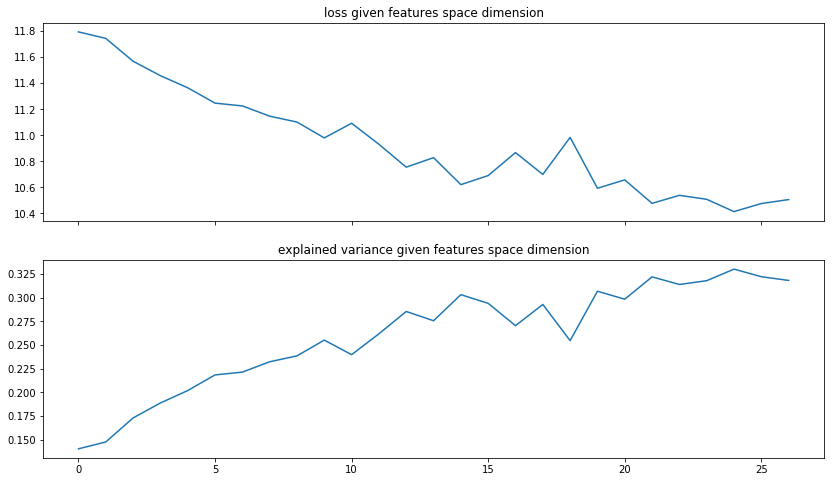

In [333]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True, figsize=[14,8])
axarr[0].plot(LOSS)
axarr[0].set_title('loss given features space dimension')
axarr[1].plot(VAR)
axarr[1].set_title('explained variance given features space dimension')
plt.show()